In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (100,100,100),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=5.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=30, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=3)

pos = 0.7

# test_phantom.add_tissue_sphere((pos,-pos,0), 2, blood)
# test_phantom.add_tissue_sphere((pos,0,0), 4, blood)
# test_phantom.add_tissue_sphere((pos,pos,0), 8, blood)

# test_phantom.add_tissue_sphere((-pos,-pos,0), 4, fat)
# test_phantom.add_tissue_sphere((-pos,0,0), 8, fat)
# test_phantom.add_tissue_sphere((-pos,pos,0), 2, fat)

# test_phantom.add_tissue_sphere((0,-pos,0), 8, myocardium)
# test_phantom.add_tissue_sphere((0,0,0), 2, myocardium)
# test_phantom.add_tissue_sphere((0,pos,0), 4, myocardium)

test_phantom.add_tissue_sphere((0,0,0), 4, myocardium)


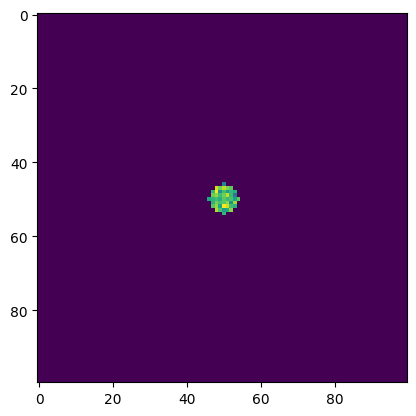

In [3]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [4]:
transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 32, 
                                    width = 20e-3,
                                    height =  20e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/2,
                                    ray_num = 16, 
                                    imaging_ndims = 2,
                                    focus_elevation = 20e-3,
                                    ) for i in range(1)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

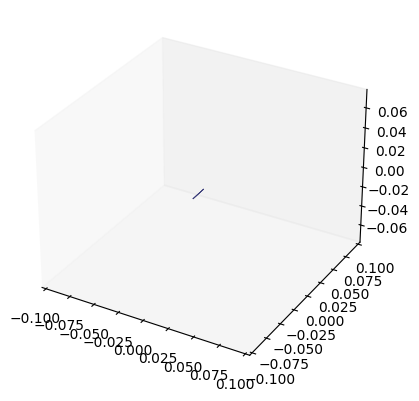

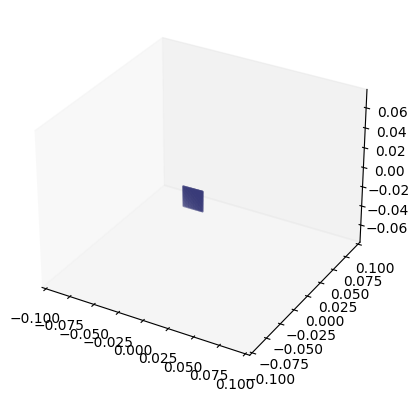

In [5]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
test_transducer_set.generate_extrinsics(shape="spherical", extrinsics_kwargs={'r_mean': 20e-3, 'view_std': 0, 'yaw_fraction': 1, 'pitch_fraction': 0, 'roll_fraction': 0})
test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [6]:
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='pressure_field')
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [7]:
simprops = simulation.SimProperties(
                grid_size   = (65e-3,60e-3,20e-3),
                voxel_size  = (0.1e-3,0.1e-3,0.1e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [8]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/planewave_test_02',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = ['p_max']
                 )

test_experiment.save()

In [9]:
# test_experiment.plot_ray_path(4)

In [10]:
test_experiment = experiment.Experiment.load('../experiment_files/planewave_test_02')
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 1/1 [00:00<00:00, 14.91it/s]


In [32]:
test_experiment.transducer_set.transducers[0].not_transducer.stored_input_signal

array([[ 0.00000000e+00],
       [ 6.54231866e-03],
       [ 2.15087822e-02],
       [ 4.59328341e-02],
       [ 7.33544849e-02],
       [ 8.57618757e-02],
       [ 5.58794917e-02],
       [-3.99885106e-02],
       [-2.01384513e-01],
       [-3.87940175e-01],
       [-5.24604791e-01],
       [-5.33990349e-01],
       [-3.81560467e-01],
       [-1.04289643e-01],
       [ 2.00598209e-01],
       [ 4.23777140e-01],
       [ 4.98928805e-01],
       [ 4.30034996e-01],
       [ 2.77182003e-01],
       [ 1.16051178e-01],
       [ 6.64358031e-17],
       [-5.50625137e-02],
       [-6.23990519e-02],
       [-4.59328341e-02],
       [-2.52850899e-02],
       [-1.01899002e-02],
       [-0.00000000e+00]])

In [11]:
test_experiment.run(repeat=False)

Found no more simulations to run.


In [12]:
test_experiment.add_results()

In [13]:
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

100%|██████████| 16/16 [00:09<00:00,  1.64it/s]


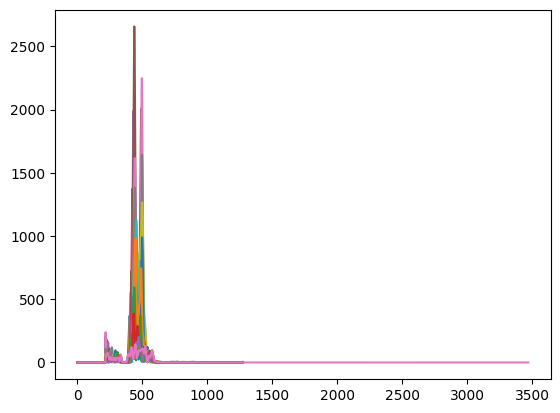

In [14]:
image = test_reconstruction.compound()

In [15]:
image.shape

(34, 34, 34)

In [16]:
test_reconstruction.results

In [17]:
element_15 = np.array([test_reconstruction.results[i][1][15] for i in range(len(test_reconstruction.results))])
element_0 = np.array([test_reconstruction.results[i][1][0] for i in range(len(test_reconstruction.results))])

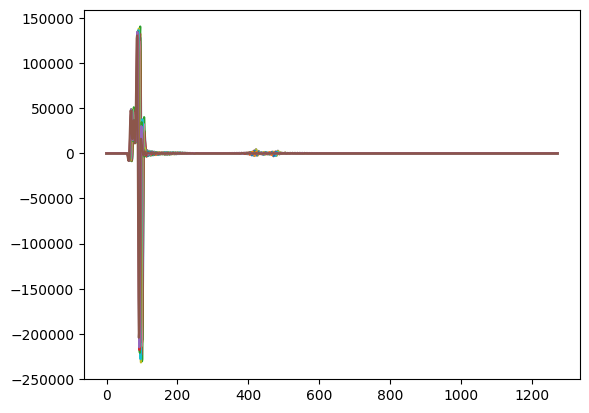

In [18]:
plt.plot(element_15.T)

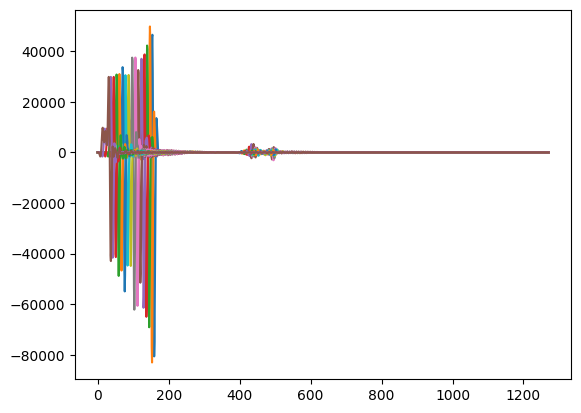

In [19]:
plt.plot(element_0.T)

In [20]:
test_reconstruction.results[0]

(array([0.0000e+00, 7.5000e-08, 1.5000e-07, ..., 9.5175e-05, 9.5250e-05,
        9.5325e-05]),
 array([[ 0.00000000e+00, -7.30268890e-04, -1.34523762e-02, ...,
          1.55056441e+00,  1.04951108e+00,  1.23727135e-01],
        [ 0.00000000e+00, -7.66717887e-04, -1.41247967e-02, ...,
          1.60621953e+00,  8.76090288e-01, -1.87227175e-01],
        [ 0.00000000e+00,  7.86948309e-04,  1.44971171e-02, ...,
          1.94880736e+00,  1.13337740e-01, -1.37787580e+00],
        ...,
        [ 0.00000000e+00,  8.90181065e-02,  1.65352428e+00, ...,
          1.50521910e+00,  4.96517032e-01, -4.97979164e-01],
        [ 0.00000000e+00, -1.59088165e-01, -2.95942855e+00, ...,
          2.11196399e+00,  4.38850552e-01, -1.29908812e+00],
        [ 0.00000000e+00, -1.45695829e+00, -3.01336346e+01, ...,
          2.41633272e+00,  1.13252103e+00, -6.95792854e-01]]),
 array([ 45794.965,  66271.766,  57038.336,  59692.426,  65821.51 ,
         59122.82 ,  65861.73 ,  65694.2  ,  66684.45 ,  66463.26 

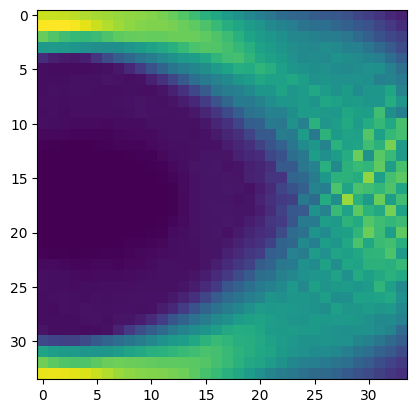

In [21]:
plt.imshow(image[:,:,image.shape[2]//2])

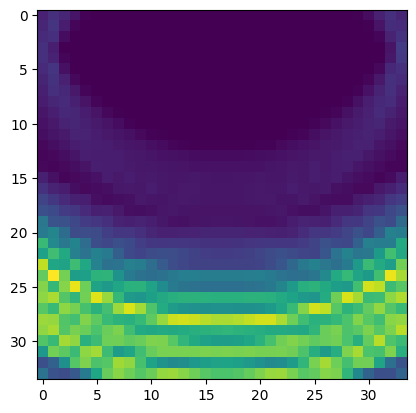

In [22]:
plt.imshow(image[image.shape[0]//2,:,:])

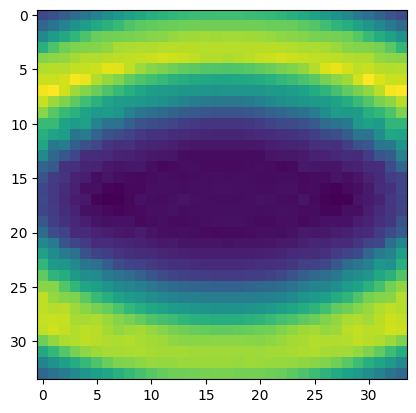

In [23]:
plt.imshow(image[:,image.shape[1]//2,:])

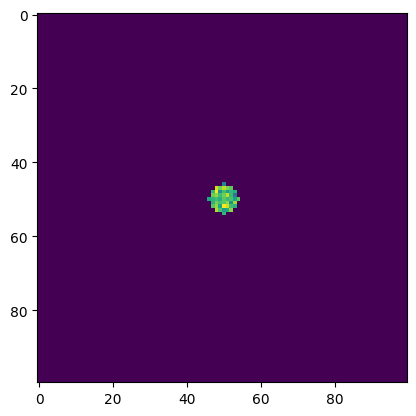

In [24]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [25]:
im = test_reconstruction.results[0][1]

In [26]:
im.shape

(32, 1272)

In [27]:
for frame in tqdm.tqdm(range(0,im.shape[-1],10)):
    plt.imshow(im[:,:,frame], cmap='bwr')
    plt.colorbar()
    plt.savefig(f'../experiment_files/outputs/frame_{str(frame).zfill(4)}.png', dpi=50)
    plt.close()

  0%|          | 0/128 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed